In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    new_val = np.dot(cur_prices, x_optimal)
    w_optimal = (x_optimal*cur_prices)/ new_val
    return x_optimal, cash_optimal, w_optimal 

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    curr_value = np.sum(x_init*cur_prices) + cash_init
    equal_wgt = (curr_value)/(len(x_init))
    x_optimal = np.floor(equal_wgt/ cur_prices)
    x_diff = abs(np.subtract(x_init, x_optimal))
    new_val = np.dot(cur_prices, x_optimal)
    w_optimal = (x_optimal*cur_prices)/ new_val
    cash_optimal = curr_value - np.sum(cur_prices*x_optimal) - (0.005*np.dot(cur_prices,x_diff))
    return x_optimal, cash_optimal, w_optimal

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # obj = w.T * Q * W
    #s.t sum(wi)= 1, wi >=0 for all i 
    
    curr_value = np.sum(x_init*cur_prices) + cash_init
    n = len(x_init)
    #initialize Cplex object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    #Define linear part of objective function and bounds on variables, no linear part
    c = [0.0]*n 
    lb = [0.0]*n
    cols = []
    for i in range(n):
        cols.append([[0],[1]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    #add linear obj, constr, lb to model
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    cpx.variables.add(obj=c, lb=lb, columns=cols, names = var_names)

    #define part of obj 
    qmat =[[list(range(n)),list(2*Q[i,:])] for i in range(n)]
    cpx.objective.set_quadratic(qmat)
    
    #set paramters
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()
    
    #retrieve optimal weight
    w_min = cpx.solution.get_values()
    w_min = np.asarray(w_min)
    w_value = w_min*curr_value
    
    #transform into money amount and get new balance of cash 
    x_optimal = np.floor(w_value/ cur_prices)
    x_diff = abs(np.subtract(x_init, x_optimal)) 
    new_val = np.dot(cur_prices, x_optimal)
    w_optimal = (x_optimal*cur_prices)/ new_val
    cash_optimal = curr_value - np.dot(cur_prices, x_optimal) - (0.005*np.dot(cur_prices,x_diff))
    return x_optimal, cash_optimal, w_optimal 

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    curr_value = np.sum(x_init*cur_prices) + cash_init
    n = len(x_init)+1
    # daily risk free rate 
    daily_rf = 1.025**(1.0/252)-1
    r_diff = mu - daily_rf
    
    #initialize Cplex object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    #Define linear part of objective function and bounds on variables, no linear part
    c = [0.0]*n 
    lb = [0.0]*n
    cols = []

    for i in range(n-1):
        cols.append([[0,1],[r_diff[i],1]])
    
    cols.append([[0,1],[0,-1]])
    var_names = ["y_%s" % i for i in range(1,n)]
    var_names.append("k")
    
    #add linear obj, constr, lb to model
    cpx.linear_constraints.add(rhs=[1.0, 0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, columns=cols, names = var_names)
    
    #define quad part of obj 
    c_k = np.zeros((20,1))        # add a col of 0 coeff for k 
    Q = np.hstack((Q,c_k))
    c_k = np.zeros((1,21))        # add a row of 0 coeff for k 
    Q = np.vstack((Q,c_k))
    
    qmat =[[list(range(n)),list(2*Q[i,:])] for i in range(n)]
    cpx.objective.set_quadratic(qmat)
    
    #set parameters
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    #solve
    cpx.solve()
    
    #retrieve optimal sol
    y_max = cpx.solution.get_values()
    y_max = np.asarray(y_max)
    kappa = y_max[-1]
    y_max = y_max[0:-1]
    
    # calculate weight using y 
    w_max = y_max/kappa
    w_value = w_max*curr_value
    x_optimal = np.floor(w_value/ cur_prices)
    x_diff = abs(np.subtract(x_init, x_optimal))  
    new_val = np.dot(cur_prices, x_optimal)
    w_optimal = (x_optimal*cur_prices)/ new_val
    cash_optimal = curr_value - np.dot(cur_prices, x_optimal) - (0.005*np.dot(cur_prices,x_diff))

    return x_optimal, cash_optimal, w_optimal

In [6]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2018 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
N_strat = 4  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:                                                             #Only re-balance the portofolio at period 1
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
            x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
         
            if cash[strategy][period-1]<0:
                curr_value = np.sum(curr_positions*cur_prices) + curr_cash       #calculate total amount of money we have 
                ratio = x[strategy][period-1]/np.sum(x[strategy][period-1])           # determine weight of rebalance port 
                dollar_excess = abs(cash[strategy][period-1])* ratio                    #excess in dollar amount wrt weight 
                pos_excess = np.ceil(dollar_excess/cur_prices)                     #excess num of stock for each stock
                x[strategy][period-1] = x[strategy][period-1] - pos_excess       #new rebalance position
                transaction_cost = np.dot(cur_prices, abs(x[strategy][period-1]-curr_positions))*0.005
                cash[strategy][period-1] = curr_value - np.sum(cur_prices*x[strategy][period-1]) - transaction_cost
            


      
        else:
            x[strategy, period-1] = x[strategy, period-2]                            #Hold the portofolio till the end of period 12
            cash[strategy, period-1] = cash[strategy, period-1]

      
      # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)




Initial portfolio value = $ 1000070.06


Period 1: start date 01/02/2019, end date 02/28/2019
  Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1121179.83
  Strategy "Equally Weighted Portfolio", value begin = $ 991124.38, value end = $ 1097031.81
  Strategy "Mininum Variance Portfolio", value begin = $ 991702.16, value end = $ 1057442.13
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990119.39, value end = $ 1016524.41

Period 2: start date 03/01/2019, end date 04/30/2019
  Strategy "Buy and Hold", value begin = $ 1126131.27, value end = $ 1075001.89
  Strategy "Equally Weighted Portfolio", value begin = $ 1100424.94, value end = $ 1186524.16
  Strategy "Mininum Variance Portfolio", value begin = $ 1059192.87, value end = $ 1106916.94
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1017182.82, value end = $ 1031812.36

Period 3: start date 05/01/2019, end date 06/28/2019
  Strategy "Buy and Hold", value begin = $ 1070867.54, value end = $

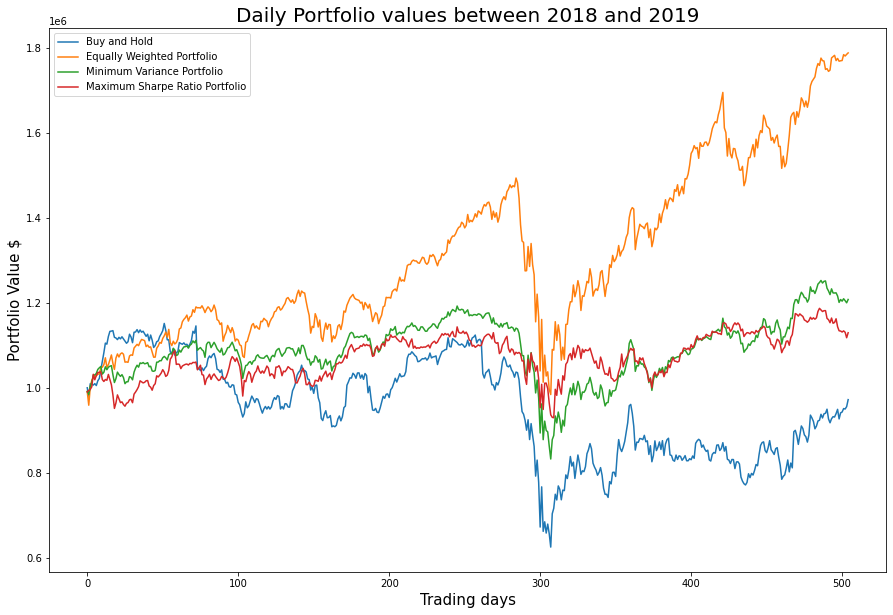

In [7]:
# Plot results
# 1. daily value of portfolio 
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(portf_value[0], label = 'Buy and Hold')
plt.plot(portf_value[1], label = 'Equally Weighted Portfolio')
plt.plot(portf_value[2], label = 'Minimum Variance Portfolio')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio Portfolio')
plt.legend()
plt.ylabel('Portfolio Value $', fontsize=15)
plt.xlabel('Trading days', fontsize=15)
plt.title('Daily Portfolio values between 2018 and 2019', fontsize= 20)
plt.savefig('PVal_2018-2019_Variantion')
plt.show()
